# KL between Bernoulli Posterior and DPP prior

This notebook demonstrates how to use importance sampling to compute the KL between a Bernoulli Posterior and DPP prior.

In [ ]:
#!pip install -U neptune-notebooks

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import torch
import numpy
from genus.util_ml import Grid_DPP, compute_logp_bernoulli, compute_entropy_bernoulli
from genus.util_vis import show_batch

In [3]:
class simplified_model(torch.nn.Module):
    def __init__(self,
                 length_scale: float=5.0,
                 weight: float=0.2,
                 mc_temperatures: list=[1.0,2.0,3.0],
                 n_mc_samples_for_temperature: int=100,
                 importance_sampling: bool=True):
        super().__init__()
        B, W, H = 8, 10, 10
        self.length_scale = length_scale
        self.weight = weight
        self.importance_sampling = importance_sampling
        self.mc_temperatures = torch.tensor(mc_temperatures, dtype=torch.float, requires_grad=False)
        self.n_mc_samples_for_temperature = n_mc_samples_for_temperature
        self.grid_dpp = Grid_DPP(length_scale=length_scale,
                                 weight=weight,
                                 learnable_params=False)
        self.logit = torch.nn.Parameter(data=torch.randn((B,1,W,H), dtype=torch.float), requires_grad=True)
        
    def sample_dpp_prior(self):
        return self.grid_dpp.sample(size=self.logit.size())
        
    
    def forward(self):

        # This term can be compute analytically
        entropy_ber = compute_entropy_bernoulli(logit=self.logit).sum(dim=(-1, -2, -3)).mean()
            
            
        if self.importance_sampling:
            # Use a Bernoulli distribution at higher temperature to evaluate the KL divergence
            temp_block = self.mc_temperatures.view(1,-1,1,1,1,1).detach()
            logit_expanded_ntb1wh = self.logit.expand([self.n_mc_samples_for_temperature,
                                                              self.mc_temperatures.shape[0],-1,-1,-1,-1]) / temp_block
            prob_expanded_ntb1wh = torch.sigmoid(logit_expanded_ntb1wh)
            c_mcsamples_ntb1wh = (torch.rand_like(prob_expanded_ntb1wh) < prob_expanded_ntb1wh)
            logp_ber_ntb = compute_logp_bernoulli(c=c_mcsamples_ntb1wh, logit=self.logit).sum(dim=(-1, -2, -3))
            with torch.no_grad():
                logp_ber_importance_ntb = compute_logp_bernoulli(c=c_mcsamples_ntb1wh,
                                                                 logit=logit_expanded_ntb1wh).sum(dim=(-1, -2, -3))
                importance_weight_ntb = (logp_ber_ntb - logp_ber_importance_ntb).exp()
                logp_dpp_ntb = self.grid_dpp.log_prob(value=c_mcsamples_ntb1wh.squeeze(-3).detach())
                baseline_tb = logp_dpp_ntb.mean(dim=0)  # average w.r.t. the samples taken and the same temperature
                d_ntb = (logp_dpp_ntb - baseline_tb)
            reinforce_ber = (importance_weight_ntb * logp_ber_ntb * d_ntb.detach()).mean()
            logit_kl_av = - entropy_ber - reinforce_ber
            
        else: 
            # Use the Bernoulli distribution at Temperature = 1 to evaluate the KL divergence
            prob_b1wh = torch.sigmoid(self.logit)
            prob_expanded_ntb1wh = prob_b1wh.expand([self.n_mc_samples_for_temperature,
                                                     self.mc_temperatures.shape[0],-1,-1,-1,-1])  # keep: batch,ch,w,h
            c_mcsamples_ntb1wh = (torch.rand_like(prob_expanded_ntb1wh) < prob_expanded_ntb1wh)
            logp_ber_ntb = compute_logp_bernoulli(c=c_mcsamples_ntb1wh.detach(), logit=self.logit).sum(dim=(-1, -2, -3))
            with torch.no_grad():
                logp_dpp_ntb = self.grid_dpp.log_prob(value=c_mcsamples_ntb1wh.squeeze(-3).detach())
                baseline_tb = logp_dpp_ntb.mean(dim=0) # average w.r.t. the samples taken and the same temperature
                d_ntb = (logp_dpp_ntb - baseline_tb)
            reinforce_ber = (logp_ber_ntb * d_ntb.detach()).mean()
            logit_kl_av = - entropy_ber - reinforce_ber
            
        loss = logit_kl_av
        c_sample = (torch.rand_like(self.logit) < torch.sigmoid(self.logit))
        return loss, c_sample, reinforce_ber

In [15]:
import neptune.new as neptune

exp = neptune.init(project='dalessioluca/genus-new')
                                    
model = simplified_model(length_scale=5.0, 
                         weight=0.2, 
                         mc_temperatures=[1.0],
                         importance_sampling=False,
                         n_mc_samples_for_temperature=10)
optimizer = torch.optim.Adam([{'params': model.parameters(), 'lr': 0.001}])

https://ui.neptune.ai/dalessioluca/genus-new/e/GEN1-242


### Log info about the simulation

In [16]:
model.mc_temperatures

tensor([1.])

In [17]:
exp["config/length_scale"].log(model.length_scale)
exp["config/weight"].log(model.weight)
exp["config/importance_sampling"].log(model.importance_sampling)
exp["config/mc_temperatures"].log(model.mc_temperatures)
exp["config/n_mc_samples_for_temperature"].log(model.n_mc_samples_for_temperature)

### Log info about the prior

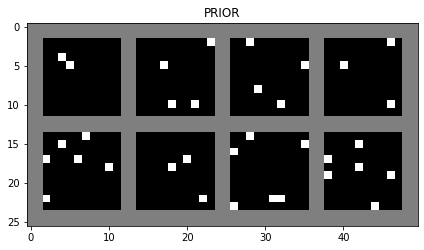

In [18]:
c_grid = model.sample_dpp_prior()
n_av = model.grid_dpp.n_mean
n_std = model.grid_dpp.n_stddev

exp["prior/n_cell_av"].log(n_av)
exp["prior/n_cell_p1sigma"].log(n_av+n_std)
exp["prior/n_cell_m1sigma"].log(n_av-n_std)

show_batch(model.logit, pad_value=1.0, n_padding=2, normalize_range=(-3.0, 3.0), 
               normalize=True, experiment=exp, neptune_name="prior/logit_raw", title="PRIOR")
show_batch(c_grid.float(), pad_value=0.5, n_padding=2, experiment=exp, neptune_name="prior/c_grid", title="PRIOR")

In [19]:
for epoch in range(10000):
    loss, c_grid, delta = model.forward()
    
    optimizer.zero_grad()
    loss.backward()  # do back_prop and compute all the gradients
    optimizer.step()  # update the parameters    
    
    if epoch % 100 == 0:
        n_cell_b = c_grid.sum(dim=(-1,-2,-3)).float()
        n_cell_std, n_cell_av = torch.std_mean(n_cell_b)
        n_cell_p1sigma = (n_cell_av+n_cell_std).detach().item()
        n_cell_m1sigma = (n_cell_av-n_cell_std).detach().item()
        
        n_cell_min = n_cell_b.min().detach().item()
        n_cell_max = n_cell_b.max().detach().item()
        exp["posterior/n_cell_av"].log(n_cell_av)
        exp["posterior/n_cell_min"].log(n_cell_min)
        exp["posterior/n_cell_max"].log(n_cell_max)        
        exp["posterior/n_cell_p1sigma"].log(n_cell_p1sigma)
        exp["posterior/n_cell_m1sigma"].log(n_cell_m1sigma)

        logit_min = torch.min(model.logit).item()
        logit_mean = torch.mean(model.logit).item()
        logit_max = torch.max(model.logit).item()
        exp["posterior/logit_min"].log(logit_min)
        exp["posterior/logit_mean"].log(logit_mean)
        exp["posterior/logit_max"].log(logit_max)
        
        exp["delta"].log(delta.detach().item())
        
        show_batch(c_grid.float(), pad_value=0.5, n_padding=2, experiment=exp, neptune_name="posterior/c_grid", 
                   title="epoch="+str(epoch))
        show_batch(model.logit, pad_value=1.0, n_padding=2, normalize_range=(-3.0, 3.0), 
               normalize=True, experiment=exp, neptune_name="posterior/logit_raw", title="epoch="+str(epoch))
        
        print(epoch, loss)

0 tensor(-43.4818, grad_fn=<SubBackward0>)
100 tensor(-61.1092, grad_fn=<SubBackward0>)
200 tensor(-70.0420, grad_fn=<SubBackward0>)
300 tensor(-82.0780, grad_fn=<SubBackward0>)
400 tensor(-96.4940, grad_fn=<SubBackward0>)
500 tensor(-64.0989, grad_fn=<SubBackward0>)
600 tensor(-77.0422, grad_fn=<SubBackward0>)
700 tensor(-110.2672, grad_fn=<SubBackward0>)
800 tensor(-116.3999, grad_fn=<SubBackward0>)
900 tensor(-101.9460, grad_fn=<SubBackward0>)
1000 tensor(-120.1823, grad_fn=<SubBackward0>)
1100 tensor(-97.9827, grad_fn=<SubBackward0>)
1200 tensor(-110.2559, grad_fn=<SubBackward0>)
1300 tensor(-114.5938, grad_fn=<SubBackward0>)
1400 tensor(-132.9603, grad_fn=<SubBackward0>)
1500 tensor(-111.7741, grad_fn=<SubBackward0>)
1600 tensor(-109.9716, grad_fn=<SubBackward0>)
1700 tensor(-119.8787, grad_fn=<SubBackward0>)
1800 tensor(-149.7139, grad_fn=<SubBackward0>)
1900 tensor(-107.3579, grad_fn=<SubBackward0>)
2000 tensor(-128.1720, grad_fn=<SubBackward0>)
2100 tensor(-137.0563, grad_fn=<S